## Stage 1

In [ ]:
!echo $HOSTNAME


df66aa1c7190


**Step 1: Environment Setup**

In [ ]:
# 🔹 Install dependencies
!pip install ultralytics opencv-python numpy tqdm matplotlib gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.7 MB/s eta 0:00:00


**Step 2: Clone LLVIP Dataset (RGB + Thermal)**

In [ ]:
# ================================================================
# 📂 Mount Drive and set dataset paths
# ================================================================
from google.colab import drive
from pathlib import Path
import pandas as pd
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to your unzipped LLVIP folder on Drive
# Update this if you placed it elsewhere
DATA_ROOT = Path("/content/drive/MyDrive/LLVIP/")

VISIBLE_DIR  = DATA_ROOT / "visible"
INFRARED_DIR = DATA_ROOT / "infrared"
ANNS_DIR     = DATA_ROOT / "Annotations"

# Quick sanity check
assert VISIBLE_DIR.exists(),  f"❌ Visible folder not found at {VISIBLE_DIR}"
assert INFRARED_DIR.exists(), f"❌ Infrared folder not found at {INFRARED_DIR}"

print("✅ Dataset directories found:")
print(f"  Visible  → {VISIBLE_DIR}")
print(f"  Infrared → {INFRARED_DIR}")
if ANNS_DIR.exists():
    print(f"  Annotations → {ANNS_DIR}")
else:
    print("⚠️ Annotations folder missing (ok for pseudo-labeling later).")

# Count files
def count_images(folder):
    return len([f for f in folder.rglob('*') if f.suffix.lower() in ['.jpg', '.png', '.jpeg']])

print(f"RGB total: {count_images(VISIBLE_DIR):>6} | IR total: {count_images(INFRARED_DIR):>6}")


Mounted at /content/drive
✅ Dataset directories found:
  Visible  → /content/drive/MyDrive/LLVIP/visible
  Infrared → /content/drive/MyDrive/LLVIP/infrared
  Annotations → /content/drive/MyDrive/LLVIP/Annotations
RGB total:  15488 | IR total:  15488


## Stage 2

**Cell A -- Paths & Pairing (build a dataframe of pairs)**

In [ ]:
# ================================================================
# 🧩 Build RGB–Thermal pairs table (train/test)
# ================================================================
from pathlib import Path
import pandas as pd

def collect_pairs(split="train"):
    vis_dir = VISIBLE_DIR / split
    ir_dir  = INFRARED_DIR / split
    assert vis_dir.exists() and ir_dir.exists(), f"Missing split '{split}'"

    vis_files = {p.stem: p for p in vis_dir.glob("*.*") if p.suffix.lower() in {".jpg",".png",".jpeg"}}
    ir_files  = {p.stem: p for p in ir_dir.glob("*.*")  if p.suffix.lower() in {".jpg",".png",".jpeg"}}

    common = sorted(set(vis_files) & set(ir_files))
    data = [{"split": split, "stem": s,
             "rgb_path": str(vis_files[s]),
             "ir_path": str(ir_files[s])} for s in common]
    return pd.DataFrame(data)

df_train = collect_pairs("train")
df_test  = collect_pairs("test")

pairs_df = pd.concat([df_train, df_test], ignore_index=True)
print(f"✅ Pairs found -> train: {len(df_train)}, test: {len(df_test)}, total: {len(pairs_df)}")
pairs_df.head()


✅ Pairs found -> train: 12025, test: 3463, total: 15488


split    stem                                           rgb_path  \
0  train  010001  /content/drive/MyDrive/LLVIP/visible/train/010...   
1  train  010002  /content/drive/MyDrive/LLVIP/visible/train/010...   
2  train  010003  /content/drive/MyDrive/LLVIP/visible/train/010...   
3  train  010004  /content/drive/MyDrive/LLVIP/visible/train/010...   
4  train  010005  /content/drive/MyDrive/LLVIP/visible/train/010...   

                                             ir_path  
0  /content/drive/MyDrive/LLVIP/infrared/train/01...  
1  /content/drive/MyDrive/LLVIP/infrared/train/01...  
2  /content/drive/MyDrive/LLVIP/infrared/train/01...  
3  /content/drive/MyDrive/LLVIP/infrared/train/01...  
4  /content/drive/MyDrive/LLVIP/infrared/train/01...

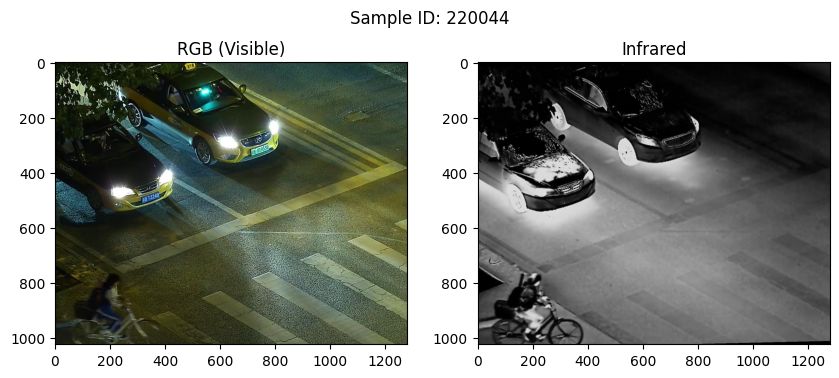

In [ ]:
# ================================================================
# 👀 Visual sanity check — one random RGB–IR pair
# ================================================================
import cv2
import matplotlib.pyplot as plt
import random

sample = pairs_df.sample(1).iloc[0]
rgb = cv2.imread(sample.rgb_path)
ir  = cv2.imread(sample.ir_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)); plt.title("RGB (Visible)")
plt.subplot(1,2,2); plt.imshow(ir, cmap='gray'); plt.title("Infrared")
plt.suptitle(f"Sample ID: {sample.stem}", fontsize=12)
plt.show()


**Cell B -- Quick Visual Check (RGB, Thermal, and simple fusion)**

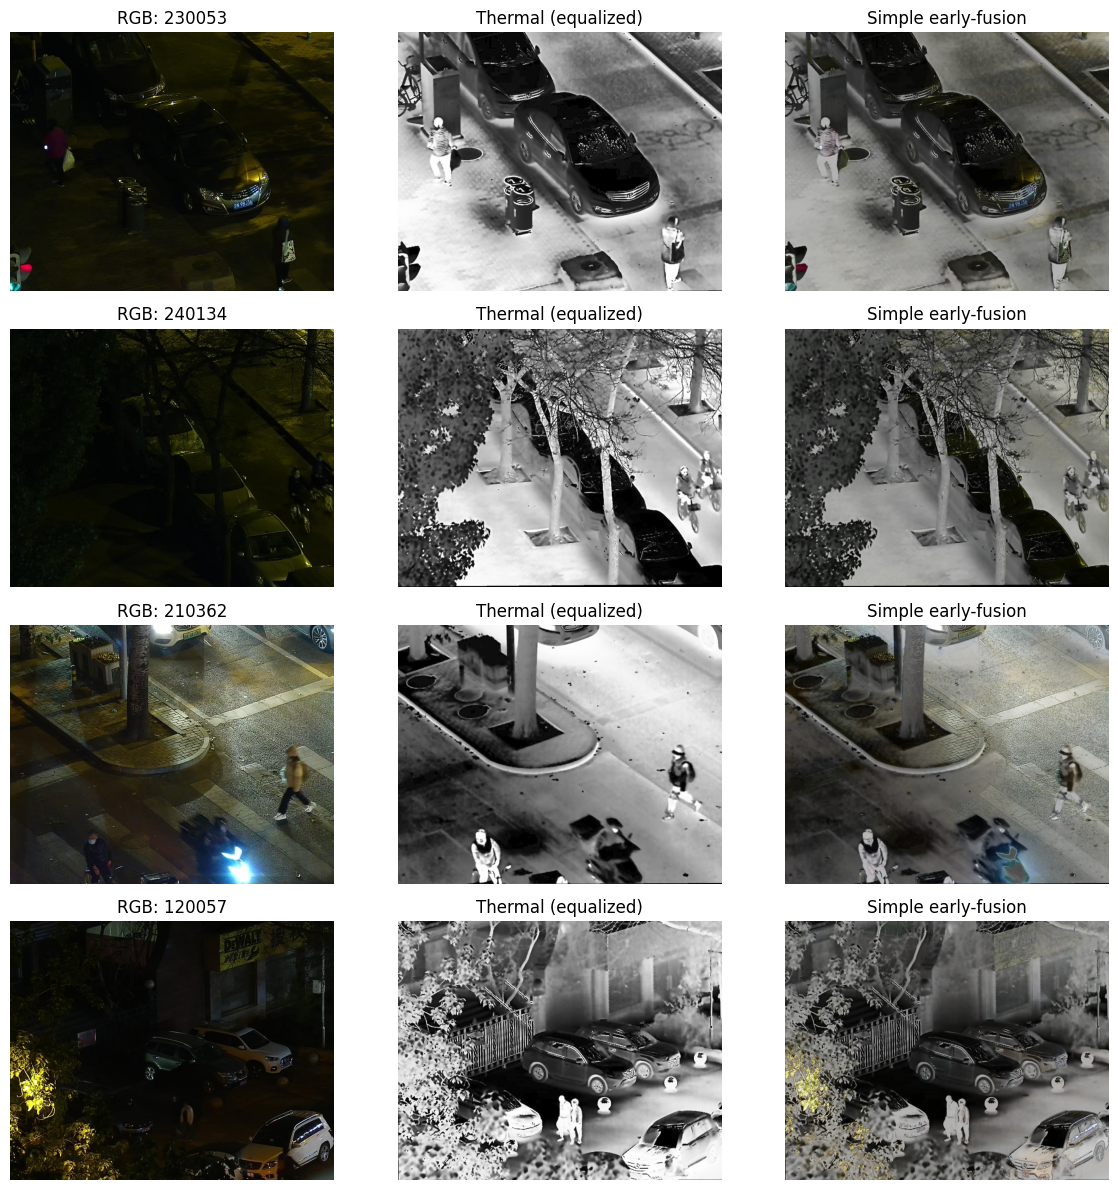

In [ ]:
# --- Cell 2: Visualize RGB–Thermal pairs and a simple fusion ---
import cv2
import numpy as np
import matplotlib.pyplot as plt

def read_rgb(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def read_ir(path):
    ir = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if ir is None:
        raise FileNotFoundError(path)
    # contrast boost for display
    ir_eq = cv2.equalizeHist(ir)
    return ir, ir_eq

def simple_early_fusion(rgb, ir_eq):
    # Resize IR to RGB size if needed
    if ir_eq.shape[:2] != rgb.shape[:2]:
        ir_eq = cv2.resize(ir_eq, (rgb.shape[1], rgb.shape[0]), interpolation=cv2.INTER_LINEAR)

    # Normalize to [0,1]
    rgb_f = rgb.astype(np.float32)/255.0
    ir_f  = (ir_eq.astype(np.float32)/255.0)[..., None]  # (H,W,1)

    # “Attention-ish” weight using RGB edge magnitude (Sobel) -> where edges are strong, keep RGB more
    gray = cv2.cvtColor((rgb_f*255).astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.float32)/255.0
    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    edge = np.clip(np.sqrt(gx**2 + gy**2), 0, 1)

    # Blend weight α in [0.3, 0.7] based on edges
    alpha = 0.3 + 0.4*edge[...,None]   # (H,W,1)
    fused = alpha*rgb_f + (1.0-alpha)*np.repeat(ir_f, 3, axis=2)

    fused = np.clip(fused, 0, 1)
    return (fused*255).astype(np.uint8)

# Show a few samples
SAMPLES = 4
sample_df = pairs_df.sample(min(SAMPLES, len(pairs_df)), random_state=42)

fig, axes = plt.subplots(SAMPLES, 3, figsize=(12, 3*SAMPLES))
if SAMPLES == 1:
    axes = np.array([axes])

for i, row in enumerate(sample_df.itertuples()):
    rgb = read_rgb(row.rgb_path)
    ir_raw, ir_eq = read_ir(row.ir_path)
    fused = simple_early_fusion(rgb, ir_eq)

    axes[i,0].imshow(rgb);   axes[i,0].set_title(f"RGB: {row.stem}")
    axes[i,1].imshow(ir_eq, cmap="gray"); axes[i,1].set_title("Thermal (equalized)")
    axes[i,2].imshow(fused); axes[i,2].set_title("Simple early-fusion")
    for j in range(3):
        axes[i,j].axis("off")

plt.tight_layout(); plt.show()


## Stage 3

**Cell A — YOLOv8 and load a COCO model (person class)**

In [ ]:
# --- Cell A: Install & load model (COCO pretrained) ---
!pip -q install ultralytics==8.3.37

from ultralytics import YOLO
import numpy as np, cv2, matplotlib.pyplot as plt
from pathlib import Path

# COCO pretrained; we'll filter to class 0 ("person")
yolo = YOLO('yolov8n.pt')  # you can try 'yolov8s.pt' for a stronger model
PERSON_CLASS_ID = 0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 kB 14.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 60.1MB/s]


**Cell B — Helpers to run inference on RGB / Thermal / Fused**

In [ ]:
# --- Cell B: Inference helpers + drawing ---
def to_bgr(img_rgb):
    return cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

def draw_boxes(img_rgb, boxes, confs, cls_ids, color=(40,185,255)):
    out = img_rgb.copy()
    for (x1,y1,x2,y2), c, k in zip(boxes, confs, cls_ids):
        if int(k) != PERSON_CLASS_ID:
            continue
        cv2.rectangle(out, (int(x1),int(y1)), (int(x2),int(y2)), color, 2)
        cv2.putText(out, f"person {c:.2f}", (int(x1), max(0, int(y1)-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)
    return out

def run_yolo_on_rgb(img_rgb, conf=0.35):
    res = yolo.predict(source=to_bgr(img_rgb), verbose=False, conf=conf)[0]
    boxes = res.boxes.xyxy.cpu().numpy() if res.boxes is not None else np.zeros((0,4))
    confs = res.boxes.conf.cpu().numpy() if res.boxes is not None else np.zeros((0,))
    cls   = res.boxes.cls.cpu().numpy() if res.boxes is not None else np.zeros((0,))
    # keep persons only
    keep = (cls == PERSON_CLASS_ID)
    return boxes[keep], confs[keep], cls[keep]


**Cell C — Run side-by-side comparisons (RGB vs Thermal vs Fused)**

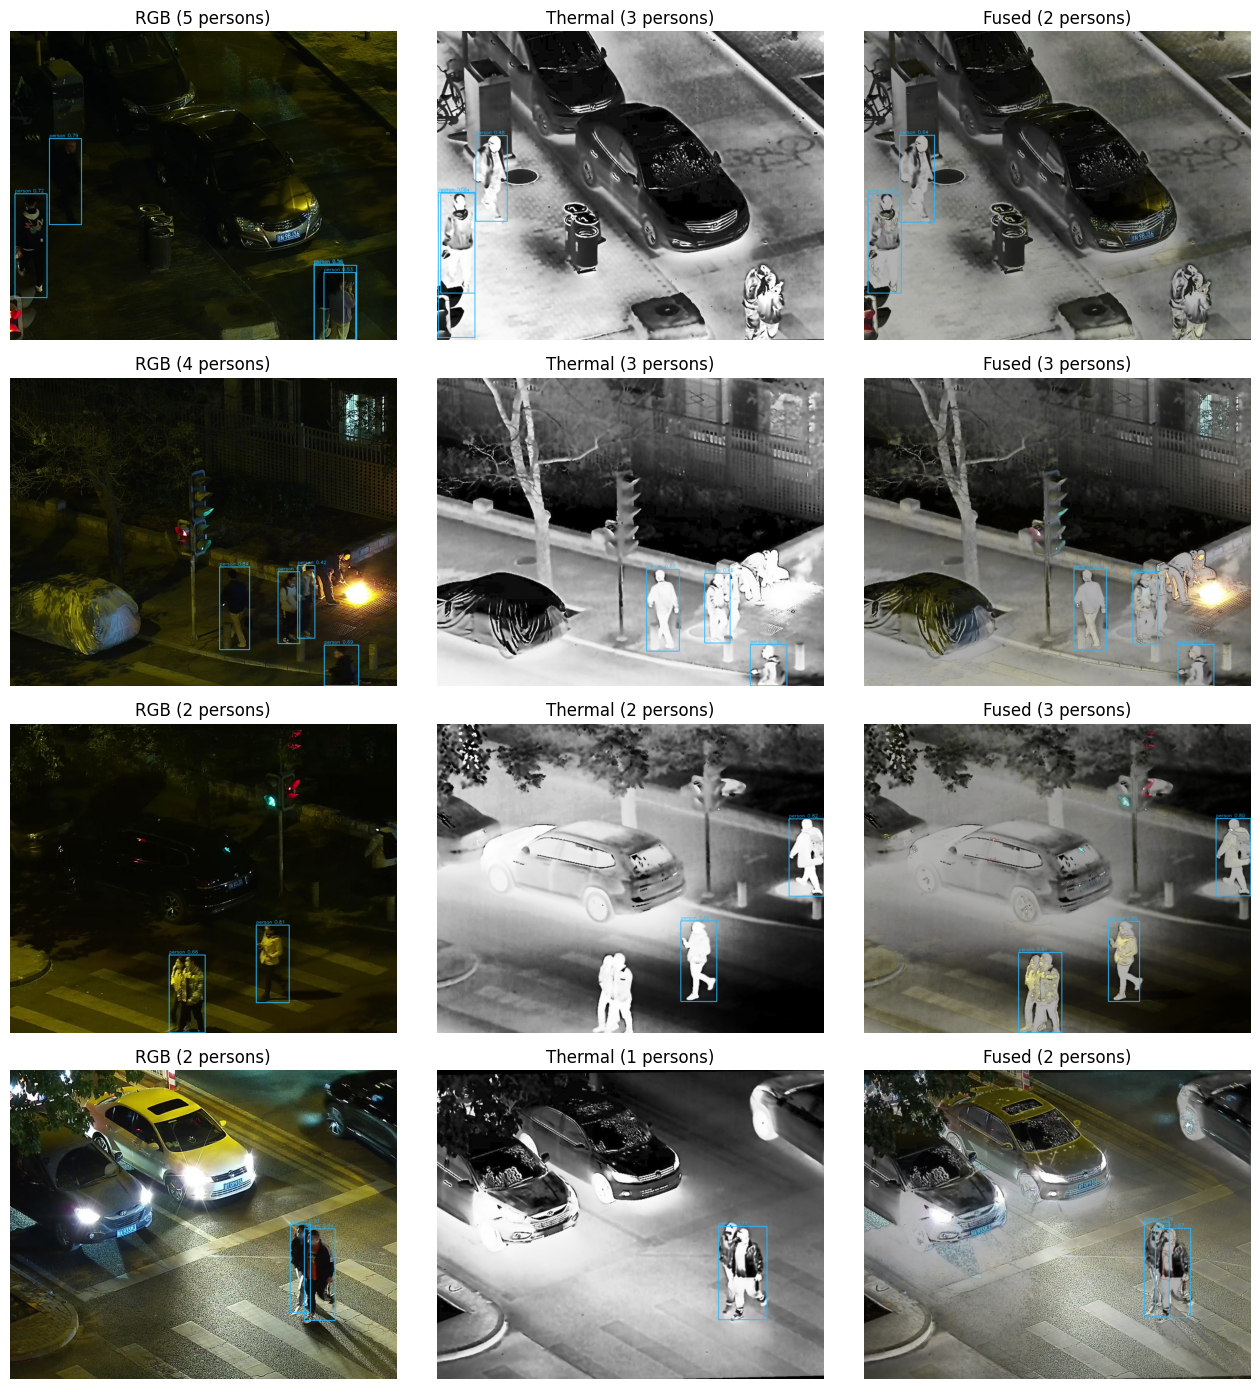

stem  rgb_count  rgb_avg_conf  ir_count  ir_avg_conf  fuse_count  \
0  230088          5      0.592276         3     0.555959           2   
1  060501          4      0.663067         3     0.634603           3   
2  091091          2      0.735676         2     0.835138           3   
3  220189          2      0.669453         1     0.714602           2   

   fuse_avg_conf  
0       0.609714  
1       0.700202  
2       0.804914  
3       0.562917

In [ ]:
# --- Cell C: Run a few samples and plot detections ---
import pandas as pd

# Reuse pairs_df, read_rgb, read_ir, simple_early_fusion from earlier cells
assert 'pairs_df' in globals(), "Run the pairing cells first!"

SAMPLES = 4
conf_thr = 0.35
sample_df = pairs_df.sample(min(SAMPLES, len(pairs_df)), random_state=7)

rows = []
fig, axes = plt.subplots(SAMPLES, 3, figsize=(13, 3.5*SAMPLES))
if SAMPLES == 1: axes = np.array([axes])

for i, row in enumerate(sample_df.itertuples()):
    # Read modalities
    rgb = read_rgb(row.rgb_path)
    _, ir_eq = read_ir(row.ir_path)
    # Make thermal 3-channel for YOLO
    ir3 = cv2.cvtColor(ir_eq, cv2.COLOR_GRAY2RGB)
    # Fused
    fused = simple_early_fusion(rgb, ir_eq)

    # YOLO inference
    b_r, c_r, k_r = run_yolo_on_rgb(rgb,   conf=conf_thr)
    b_t, c_t, k_t = run_yolo_on_rgb(ir3,   conf=conf_thr)
    b_f, c_f, k_f = run_yolo_on_rgb(fused, conf=conf_thr)

    # Draw
    axes[i,0].imshow(draw_boxes(rgb,   b_r, c_r, k_r)); axes[i,0].set_title(f"RGB ({len(c_r)} persons)")
    axes[i,1].imshow(draw_boxes(ir3,   b_t, c_t, k_t)); axes[i,1].set_title(f"Thermal ({len(c_t)} persons)")
    axes[i,2].imshow(draw_boxes(fused, b_f, c_f, k_f)); axes[i,2].set_title(f"Fused ({len(c_f)} persons)")
    for j in range(3): axes[i,j].axis("off")

    rows.append({
        "stem": row.stem,
        "rgb_count": len(c_r), "rgb_avg_conf": float(np.mean(c_r)) if len(c_r) else 0.0,
        "ir_count":  len(c_t), "ir_avg_conf":  float(np.mean(c_t)) if len(c_t) else 0.0,
        "fuse_count":len(c_f), "fuse_avg_conf":float(np.mean(c_f)) if len(c_f) else 0.0,
    })

plt.tight_layout(); plt.show()

summary = pd.DataFrame(rows)
summary


**Cell D — Quick proxy summary (no GT labels yet)**

In [ ]:
# --- Cell D: Aggregate quick proxy metrics ---
def agg(df, prefix):
    return {
        f"{prefix}_avg_count":  float(df[f"{prefix}_count"].mean()),
        f"{prefix}_avg_conf":   float(df[f"{prefix}_avg_conf"].mean()),
    }

agg_metrics = {**agg(summary, "rgb"), **agg(summary, "ir"), **agg(summary, "fuse")}
agg_metrics


{'rgb_avg_count': 3.25,
 'rgb_avg_conf': 0.6651177853345871,
 'ir_avg_count': 2.25,
 'ir_avg_conf': 0.6850752979516983,
 'fuse_avg_count': 2.5,
 'fuse_avg_conf': 0.6694368124008179}